In [ ]:
%pip install -i https://test.pypi.org/simple/ VASA==0.0.4

In [1]:
import os
import sys
import geopandas as gpd
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.pardir)))
from VASA import VASA

/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# CBG Map of California
counties_map = gpd.GeoDataFrame \
    .from_features(gpd.read_file("../data/ca_cbg")) \
    .set_crs(epsg=4326) \
    .to_crs("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")

counties_map = counties_map[counties_map.ALAND > 0]

In [3]:
#Lake Fire 2019 Data
fire2019 = pd.read_csv("../data/lakefire2019_data.csv")
fire2019.origin_census_block_group = "0" + fire2019.origin_census_block_group.astype(str)

In [4]:
# unique_tracts = np.unique([g[:8] for g in fire2019.origin_census_block_group])
# tract_map = counties_map[[(cbg[:8] in unique_tracts) for cbg in counties_map.GEOID]]

In [4]:
v = VASA(
    df=fire2019[["origin_census_block_group", "date_range_start", "distance_traveled_from_home"]],
    gdf=counties_map,
    group_summary=lambda g: g[:5], # county level
    df_group_col="origin_census_block_group",
    gdf_group_col="GEOID",
    date_col="date_range_start",
    temp_res="week",
    date_format="%Y-%m-%d %H:%M:%S"
)

In [5]:
del fire2019

In [6]:
v.filter_group()

In [7]:
v.group()

In [8]:
v.fill_missing()

In [9]:
v.lisa(k=2, type="union")

/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 66 disconnected components.
  warnings.warn(message)


('WARNING: ', 1796, ' is an island (no neighbors)')
('WARNING: ', 5276, ' is an island (no neighbors)')
('WARNING: ', 5962, ' is an island (no neighbors)')
('WARNING: ', 9872, ' is an island (no neighbors)')


/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 1796, 5276, 5962, 9872.
  warnings.warn(message)
/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/esda/moran.py:1054: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/esda/moran.py:1054: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/esda/moran.py:1054: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/esda/moran.py:1054: RuntimeWarning: invalid value encountered in true_divi

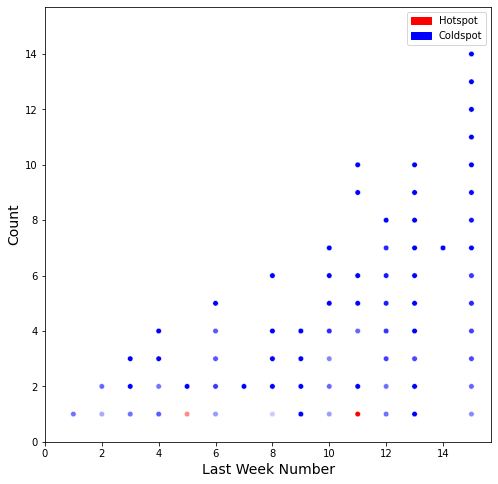

In [63]:
# from VASA.scatter import Scatter
sc = Scatter(v)
# sc.plot(highlight = "06037")
sc.plot(highlight = "")

In [64]:
import os
import matplotlib.pyplot as plt
import numpy as np

def set_fig(f):
    def func(self, *args, **kwargs):
        plt.figure(self._fig.number)
        return f(self, *args, **kwargs)
    return func
    
class PlotUtility:
    
    def __init__(self, fig, output_folder):
        self._plot_font_size=12
        self._fig = fig
        self._output_folder = f"{output_folder}/"

        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

    def hide_axis(self, ax):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    
    @set_fig
    def save_plot(self, title):
        self._fig.set_facecolor("w")
        plt.savefig(
            self._output_folder + title + ".png", 
            bbox_inches='tight', 
            dpi=150
        )

    @set_fig
    def reduce_padding(self):
        plt.subplots_adjust(hspace=0)

    # allows indexing of all dimensions
    def get_axis(self, axes, row, col):
        try:
            return axes[row, col] # dimension is some (n, m); n,m > 1
        except:
            try:
                return axes[col] if row == 1 else axes[row] # dimension is (1, n); n > 1
            except:
                return axes # dimension is (1, 1)

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import geopandas as gpd
import math

class StackedChoropleth:

    def __init__(self, v, main_folder, desc="", titles='', plot_dim=None, fips_order=None):

        cols = v.cols

        if not isinstance(titles, list):
            titles = [titles]

        if not plot_dim:
            tot = len(cols) 
            if tot > 1:
                plot_dim = (2, math.ceil(tot / 2))
            if tot == 1:
                plot_dim = (1, 1)

        self._gpd_maps = [v.gdf]
        self._cols = cols
        self.v = v
        self._plot_dim = plot_dim
        self._desc = desc if desc else "-".join(cols)
        self._titles = titles if titles else cols

        self._fips_order = v.fips_order
        self._state_col = "STATEFP"

        self.count_subfolder = f'{main_folder}/count/'
        self.recent_subfolder = f'{main_folder}/recent/'
        self.both_subfolder = f'{main_folder}/combined/'
        self.scatter_subfolder = f'{main_folder}/scatter/'

        self._count_labels = ["Low Count", "High Count"]
        self._recent_labels = ["1/1/2020", "12/31/2020"]
        self._count_title = "Number of Weeks"
        self._recent_title = "Recency"

        self._plot_title_size = 14
        self._font_size = 12

        self._figsize = (10, 8)
        # self._figsize = (1, 4)

    #
    #   MAPPING OPTIONS
    #

    def plot_count(self):
        if '_collapse_count_hot' not in locals():
            self.__collapse_count()

        self.__create_choropleth(
            self._collapse_count_hot,
            self._collapse_count_cold,
            typ=self._count_title, 
            labels=self._count_labels,  # Start date to End Date
            figsize=self._figsize,
            output_folder=self.count_subfolder
        )

    def plot_recent(self):
        if '_collapse_recent_hot' not in locals():
            self.__collapse_recent()
        
        self.__create_choropleth(
            self._collapse_recent_hot, 
            self._collapse_recent_cold, 
            typ=self._recent_title, 
            labels=self._recent_labels, # maybe actual values?
            figsize=self._figsize,
            output_folder=self.recent_subfolder
        )

    def plot_both(self):
        if '_collapse_count_combined' not in locals():
            self.__collapse_count_combined()

        if '_collapse_recent_hot' not in locals():
            self.__collapse_recent()
        
        hots = self._collapse_recent_hot
        colds = self._collapse_recent_cold

        fig, axes = plt.subplots(
            self._plot_dim[0],
            self._plot_dim[1],
            figsize=self._figsize,
        )
        fig.tight_layout()
        #plt.subplots_adjust(hspace=0.1)

        utility = PlotUtility(fig, self.both_subfolder)
        utility.reduce_padding()

        # Since I'm restricting maps OR col to be a single item this is really a single loop:
        for map_idx, gpd_map in enumerate(self._gpd_maps):

            for j, col in enumerate(self._cols):

                map_copy = gpd_map.copy()

                map_copy["geometry"] = [
                    col.centroid.buffer(500 + 1100/4 * count)
                    # col.centroid.buffer(2500 + 11000/40 * count)
                    # col.centroid.buffer(10000 + 11000/40 * count)
                    for col, count in zip(map_copy['geometry'], self._collapse_count_combined[col])
                ]
                # Row wise:
                ax = utility.get_axis(axes, (map_idx + j) // self._plot_dim[0], (map_idx + j) % self._plot_dim[1])

                # if True: #self._region and self._region[map_idx] == "usa":
                #     ax.set_xlim([-0.235e7, 0.22e7])
                #     ax.set_ylim([-1.75e6, 1.45e6])
                # elif self._region[map_idx] == "ca":
                #     ax.set_xlim([-2.60e6, -1.563e6])
                #     ax.set_ylim([-1e6, 0.65e6])
                # elif self._region[map_idx] == "fl":
                #     ax.set_xlim([0.730e6, 1.570e6])
                #     ax.set_ylim([-1.700e6, -0.950e6])
                # elif self._region[map_idx] == "ny":
                #     ax.set_xlim([1.1e6, 2.0e6])
                #     ax.set_ylim([.03e6, 0.9e6])
                # elif self._region[map_idx] == "tx":
                #     ax.set_xlim([-0.990e6, 0.24e6])
                #     ax.set_ylim([-1.75e6, -0.380e6])

                # if adding new state start with looking at state bounds:
                # print(gpd_map.total_bounds)

                norm = colors.Normalize(vmin=1, vmax=max([*hots[col], *colds[col]]))

                if len(self._titles) > 1:
                    ax.set_title(self._titles[map_idx + j], fontsize=self._plot_title_size)
                utility.hide_axis(ax)

                #self.__show_country_outline(ax, gpd_map)
                self.__show_state_outline(ax, gpd_map)
                self.__create_choropleth_map(hots[col], ax, map_copy, self.__get_pallete("Reds"), norm, edgecolor='white')
                self.__create_choropleth_map(colds[col], ax, map_copy, self.__get_pallete("Blues"), norm, edgecolor='white')
                
        if len(self._titles) == 1:
            fig.suptitle(self._titles[0], fontsize=self._plot_title_size)

        self.__create_choropleth_legend_horiz(fig, self._recent_title, self._recent_labels)
        self.__create_choropleth_legend_circles(fig, self._count_labels)
        utility.save_plot(self._desc)

    #
    #   MAP FEATURES
    #

    def __create_choropleth(self, hots, colds, typ, labels, figsize, output_folder):
        fig, axes = plt.subplots(
            self._plot_dim[0], 
            self._plot_dim[1], 
            figsize=figsize
        )
        fig.tight_layout()
        utility = PlotUtility(fig, output_folder)
        utility.reduce_padding()

        # Since I'm restricting maps OR col to be a single item this is really a single loop:
        for map_idx, gpd_map in enumerate(self._gpd_maps):

            for j, col in enumerate(self._cols):
                # Row wise:
                ax = utility.get_axis(axes, (map_idx + j) // self._plot_dim[0], (map_idx + j) % self._plot_dim[1])

                norm = colors.Normalize(vmin=0.5, vmax=max([*hots[col], *colds[col]]))
                ax.set_title(self._titles[map_idx + j], fontsize=self._plot_title_size)
                ax.set_axis_off()

                #self.__show_country_outline(ax, gpd_map)
                self.__show_state_outline(ax, gpd_map)
                self.__create_choropleth_map(hots[col], ax, gpd_map, self.__get_pallete("Reds"), norm, edgecolor='black')
                self.__create_choropleth_map(colds[col], ax, gpd_map, self.__get_pallete("Blues"), norm, edgecolor='black')
        
        self.__create_choropleth_legend_horiz(fig, typ, labels)

        utility.save_plot(self._desc)
        plt.close(fig)

    def __create_choropleth_map(self, data, ax, gpd_map, palette, norm, **kwargs):
        gpd_map \
            .assign(cl = data) \
            .plot(column='cl', k=2, cmap=palette, ax=ax, linewidth=0, norm=norm, **kwargs)

    def __create_choropleth_legend_horiz(self, fig, typ, labels):
        #
        #   THIS NEEDS TO BE LOOKED INTO
        #
        start_x = 0.12 
        start_y = -0.07 # 0 for non tight
        
        newa = fig.add_axes([start_x, start_y + 0.04, 0.3, 0.03])
        sm = plt.cm.ScalarMappable(cmap="Reds")
        cb = plt.colorbar(sm, cax=newa, ticks=[], orientation="horizontal")
        cb.ax.tick_params(size=0)
        cb.ax.set_xlabel(typ, fontsize=self._font_size)
        cb.ax.xaxis.set_label_position("top")
        cb.ax.set_ylabel("Hot Spots", rotation=0, labelpad=35, y=0.125, fontsize=self._font_size)

        newa = fig.add_axes([start_x, start_y + 0, 0.3, 0.03])
        sm = plt.cm.ScalarMappable(cmap="Blues")
        cb = plt.colorbar(sm, cax=newa, ticks=[0.1, 0.875], orientation="horizontal")
        cb.ax.set_xticklabels(labels, fontsize=self._font_size)
        cb.ax.tick_params(size=0)
        cb.ax.set_ylabel("Cold Spots", rotation=0, labelpad=35, y=0.125, fontsize=self._font_size)

    def __create_choropleth_legend_vert(self, fig, typ, labels):
        #
        #   THIS NEEDS TO BE ADDED
        #
        return 1

    def __create_choropleth_legend_circles(self, fig, labels):
        start_y = -0.06 # 0 for non tight
        start_x = .58 # 0.5 for non tight
        
        if self._plot_dim[0] == 1 and self._plot_dim[1] == 1:
            point_scale = lambda i: (15000 + 55000/40 * i) / 2500
        else:
            point_scale = lambda i: (10000 + 11000/40 * i) / 2500

        newa = fig.add_axes([start_x, start_y + 0.07, 0.3, 0.03])
        points = [1, 5, 10, 20, 52]
        point_lgd = [plt.scatter([],[], s=point_scale(i), marker='o', color='k') for i in points]
        newa.legend(point_lgd, points, frameon=False, title=self._count_title, ncol=5, handlelength=0.1)
        newa.set_axis_off()


    #
    #   UTILITY MAPPING FUNCTIONS
    #

    def __show_country_outline(self, ax, gpd_map):
        gpd_map \
            .assign(dissolve = 0) \
            .dissolve(by="dissolve") \
            .plot(color="#FFFFFF00", ax=ax, edgecolor='black', linewidth=3)
        
    def __show_state_outline(self, ax, gpd_map):
        gpd_map \
            .dissolve(by=self._state_col) \
            .plot(color="#FFFFFF00", ax=ax, edgecolor='black', linewidth=1)

    def __get_pallete(self, which):
        import copy

        palette = copy.copy(plt.get_cmap(which))
        palette.set_under("#FFFFFF00", 0)
        return palette

    #
    #   CALCULATIONS:
    #
    def __collapse_count_combined(self):
        self._collapse_count_combined = self.v.reduce('count_combined')

    def __collapse_count(self):
        self._collapse_count_hot = self.v.reduce("count_hh")
        self._collapse_count_cold = self.v.reduce("count_ll")
        
    def __collapse_recent(self):
        self._collapse_recent_hot = self.v.reduce("recency_hh")
        self._collapse_recent_cold = self.v.reduce("recency_ll")

    def __filter_state(self, map_data, arr):
    
        if self._fips_order is None:
            return arr
        
        data = pd.DataFrame()
        data["fips"] = self._fips_order
        data["val"] = arr

        return map_data.merge(data, how="left", on="fips")["val"]

    #
    #
    #   ALTERNATIVE MAPS
    #   
    #

    def __create_scatter(self, ax, xs, ys):
        ax.scatter(xs, ys, c="blue", alpha=0.3)
        ax.plot(range(0, max(xs) + 1), range(0, max(xs) + 1))

    def scatter(self):
        if '_collapse_count_combined' not in locals():
            self.__collapse_count_combined()

        if '_collapse_recent_hot' not in locals():
            self.__collapse_recent()
        
        fig, axes = plt.subplots(
            self._plot_dim[0], 
            self._plot_dim[1], 
            figsize=self._figsize
        )
        fig.tight_layout()
        utility = PlotUtility(fig, self.scatter_subfolder)
        utility.reduce_padding()

        # Since I'm restricting maps OR col to be a single item this is really a single loop:
        for map_idx, gpd_map in enumerate(self._gpd_maps):

            for j, col in enumerate(self._cols):
                # Row wise:
                ax = utility.get_axis(axes, (map_idx + j) // self._plot_dim[0], (map_idx + j) % self._plot_dim[1])

                ys = self._collapse_count_combined[map_idx + j]
                xs = [(a if a > b else b) for a, b in zip(self._collapse_recent_hot[map_idx + j], self._collapse_recent_cold[map_idx + j])]

                ax.set_title(self._titles[map_idx + j], fontsize=self._plot_title_size)
                self.__create_scatter(ax, xs, ys)    

        utility.save_plot(self._desc)

    def separate_hot_cold(self):
        if '_collapse_count_hot' not in locals():
            self.__collapse_count()

        if '_collapse_recent_hot' not in locals():
            self.__collapse_recent()
        
        fig, axes = plt.subplots(
            self._plot_dim[0] * self._plot_dim[1], 
            2, 
            figsize=self._figsize
        )
        fig.tight_layout()
        utility = PlotUtility(fig, self.scatter_subfolder)
        utility.reduce_padding()

        hots = self._collapse_count_hot
        colds = self._collapse_count_cold

        # Since I'm restricting maps OR col to be a single item this is really a single loop:
        for map_idx, gpd_map in enumerate(self._gpd_maps):

            for j, col in enumerate(self._cols):
                # Row wise:
                ax_hot = utility.get_axis(axes, map_idx + j, 0)
                ax_cold = utility.get_axis(axes, map_idx + j, 1)

                norm = colors.Normalize(vmin=0.5, vmax=max([*hots[map_idx + j], *colds[map_idx + j]]))
                ax_hot.set_title(self._titles[map_idx + j], fontsize=self._plot_title_size)
                ax_cold.set_title(self._titles[map_idx + j], fontsize=self._plot_title_size)
                ax_hot.set_axis_off()
                ax_cold.set_axis_off()

                #self.__show_country_outline(ax, gpd_map)
                self.__show_state_outline(ax_hot, gpd_map)
                self.__show_state_outline(ax_cold, gpd_map)
                self.__create_choropleth_map(hots[map_idx + j], ax_hot, gpd_map, self.__get_pallete("Reds"), norm, edgecolor='black')
                self.__create_choropleth_map(colds[map_idx + j], ax_cold, gpd_map, self.__get_pallete("Blues"), norm, edgecolor='black')
        

        utility.save_plot(self._desc)

    def hot_cold(self):
        if '_collapse_count_hot' not in locals():
            self.__collapse_count()

        if '_collapse_recent_hot' not in locals():
            self.__collapse_recent()
        
        fig, axes = plt.subplots(
            self._plot_dim[0], 
            self._plot_dim[1], 
            figsize=self._figsize
        )
        fig.tight_layout()
        utility = PlotUtility(fig, self.scatter_subfolder)
        utility.reduce_padding()

        hots = self._collapse_count_hot
        colds = self._collapse_count_cold

        # Since I'm restricting maps OR col to be a single item this is really a single loop:
        for map_idx, gpd_map in enumerate(self._gpd_maps):

            for j, col in enumerate(self._cols):
                # Row wise:
                ax = utility.get_axis(axes, (map_idx + j) // self._plot_dim[0], (map_idx + j) % self._plot_dim[1])

                norm = colors.Normalize(vmin=0.5, vmax=max([*hots[map_idx + j], *colds[map_idx + j]]))
                ax.set_title(self._titles[map_idx + j], fontsize=self._plot_title_size)
                ax.set_axis_off()

                #self.__show_country_outline(ax, gpd_map)
                self.__show_state_outline(ax, gpd_map)
                self.__create_choropleth_map(hots[map_idx + j], ax, gpd_map, self.__get_pallete("Reds"), norm, edgecolor='black')
                self.__create_choropleth_map(colds[map_idx + j], ax, gpd_map, self.__get_pallete("Blues"), norm, edgecolor='black')
        


        utility.save_plot(self._desc)

In [12]:
from VASA.static_choropleth import StackedChoropleth

In [65]:
stcked = StackedChoropleth(v, os.getcwd())
stcked.plot_count()

![](count/distance_traveled_from_home.png)

In [14]:
stcked = StackedChoropleth(v, os.getcwd())
stcked.plot_recent()

![](recent/distance_traveled_from_home.png)

In [ ]:
stcked = StackedChoropleth(v, os.getcwd())
stcked.plot_both()

![](combined/distance_traveled_from_home.png)

In [ ]:
#from VASA.stripplot import Strip

# This is trying to merge with the state names csv, which doesn't make sense for this

st = Strip(v)

def group_id(f):
    return int(f[:8])

st.plot(group_id)